# More detail

In this notebook, I try different models to compare with my original model. However, the approach I used has some errors, so the output is just for reference. As my teacher recommended, when trying to use other models for this task, I need to use other techniques such as transfer learning or fine-tuning (which I have done in the nb4 notebook). You can check this notebook for more details.

# Import library

In [1]:
import cv2
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from keras.utils import normalize
from PIL import Image
from sklearn.model_selection import train_test_split

# Reading dataset

In [2]:
no_dir = os.listdir('./data_no/data_no/NO/')
yes_dir = os.listdir('./data_yes/data_yes/YES/')

In [3]:
len(no_dir)

535

In [4]:
len(yes_dir)

557

In [5]:
data_set,label = [],[]
for i,cur_img_dir in enumerate(no_dir):
    #check type of image
    if cur_img_dir.split('.')[1]=='jpg':
        img = cv2.imread('./data_no/data_no/NO/'+cur_img_dir)
        img = Image.fromarray(img,'RGB')
        img = img.resize((64,64))
        data_set.append(np.array(img))
        label.append(0)

In [6]:
for i,cur_img_dir in enumerate(yes_dir):
    #check type of image
    if cur_img_dir.split('.')[1]=='jpg':
        img = cv2.imread('./data_yes/data_yes/YES/'+cur_img_dir)
        img = Image.fromarray(img,'RGB')
        img = img.resize((64,64))
        data_set.append(np.array(img))
        label.append(1)

In [7]:
data_set = np.array(data_set)
label = np.array(label)
data_set.shape

(1092, 64, 64, 3)

In [8]:
label.shape

(1092,)

In [9]:
print(f'yes observe:{sum(label)}, no observe:{len(label)-sum(label)}')

yes observe:557, no observe:535


# Split and normalize data


## 1. Split


In [11]:
import random
seed = 99
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [12]:
x_train,x_test,y_train,y_test = train_test_split(
    data_set,label,
    test_size=0.2,
    )
x_train,x_val,y_train,y_val = train_test_split(
        x_train,y_train,
    test_size=0.25,
)


In [12]:
print(f'X train shape: {x_train.shape}\nY train shape: {y_train.shape}\nX test shape: {x_test.shape}\nY test shape: {y_test.shape}\nX validation shape: {x_val.shape}\nY validation shape: {x_val.shape}')

X train shape: (654, 64, 64, 3)
Y train shape: (654,)
X test shape: (219, 64, 64, 3)
Y test shape: (219,)
X validation shape: (219, 64, 64, 3)
Y validation shape: (219, 64, 64, 3)


## 2. Normalize

In [13]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import joblib 
# using scaler of nb4
scaler = joblib.load('scaler.pkl') 
# Reshape data to fit with MinMaxScaler
x_train_reshaped = x_train.reshape(-1, x_train.shape[-1])
x_test_reshaped = x_test.reshape(-1, x_test.shape[-1])
x_val_reshaped = x_val.reshape(-1, x_val.shape[-1])

x_train_reshaped = scaler.fit_transform(x_train_reshaped)
x_test_reshaped = scaler.transform(x_test_reshaped)
x_val_reshaped = scaler.transform(x_val_reshaped)
# Print mean and std after scaling
print("\nAfter scaling:")
print(f"Train mean: {x_train_reshaped.mean(axis=0)}")
print(f"Train std: {x_train_reshaped.std(axis=0)}")
print(f"Test mean: {x_test_reshaped.mean(axis=0)}")
print(f"Test std: {x_test_reshaped.std(axis=0)}")
print(f"Validation mean: {x_val_reshaped.mean(axis=0)}")
print(f"Validation std: {x_val_reshaped.std(axis=0)}")


# Reshape to original shape
x_train = x_train_reshaped.reshape(x_train.shape)
x_test = x_test_reshaped.reshape(x_test.shape)
x_val = x_val_reshaped.reshape(x_val.shape)


After scaling:
Train mean: [4.73241486e-14 4.73241486e-14 4.73241486e-14]
Train std: [1. 1. 1.]
Test mean: [0.03089532 0.03089532 0.03089532]
Test std: [1.01023685 1.01023685 1.01023685]
Validation mean: [0.02535402 0.02535402 0.02535402]
Validation std: [1.00168052 1.00168052 1.00168052]


# Building Model

In [14]:
from keras.models import Sequential 
from keras.layers import (
    Conv2D,
    MaxPooling2D,
    Activation,
    Dropout,
    Flatten,
    Dense
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, MaxPooling2D, Dropout
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
import numpy as np

In [26]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
def create_original_model():
    INPUT_SIZE = 64
    weight_decay = 1e-4

    model = Sequential()

    # First Convolutional Layer
    model.add(Conv2D(32, (3, 3), input_shape=(INPUT_SIZE, INPUT_SIZE, 3), kernel_regularizer=l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional Layer
    model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third Convolutional Layer
    model.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten and Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(64, kernel_regularizer=l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    # Output Layer
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

# Try other network to choose the best model


## LeNet-5

In [27]:
INPUT_SIZE = 64

def create_lenet5():
    model = Sequential([
        Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(INPUT_SIZE, INPUT_SIZE, 3)),
        AveragePooling2D(pool_size=(2, 2)),
        Conv2D(16, kernel_size=(5, 5), activation='tanh'),
        AveragePooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(120, activation='tanh'),
        Dense(84, activation='tanh'),
        Dense(1, activation='sigmoid')
    ])
    return model

## AlexNet

In [28]:

INPUT_SIZE = 64

def create_alexnet():
    model = Sequential([
        Conv2D(96, kernel_size=(11, 11), strides=4, activation='relu', input_shape=(INPUT_SIZE, INPUT_SIZE, 3)),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'),
        Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'),
        Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=2),  # Adjusted pooling size
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

## MobileNet

In [29]:

INPUT_SIZE = 64

def create_mobilenet():
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(INPUT_SIZE, INPUT_SIZE, 3))
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

### Compile and train models

In [30]:
def compile_and_train(model, x_train, y_train, x_val, y_val):
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(amsgrad=True),
        metrics=['accuracy']
    )
    history = model.fit(
        x_train,
        y_train,
        batch_size=16,
        verbose=1,
        epochs=10,
        validation_data=(x_val, y_val),
        shuffle=False
    )
    loss, accuracy = model.evaluate(x_val, y_val)
    return accuracy

# Training model

In [31]:
models = [
    ('Original', create_original_model()),
    ('LeNet-5', create_lenet5()),
    ('AlexNet', create_alexnet()),
    ('MobileNet', create_mobilenet()),
]
accuracies = []


C:\Users\Admin\AppData\Local\Temp\ipykernel_16864\4043771889.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(INPUT_SIZE, INPUT_SIZE, 3))


In [32]:
for name, model in models:
    accuracy = compile_and_train(model, x_train, y_train, x_val, y_val)
    accuracies.append((name, accuracy))

Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.6472 - loss: 0.7008 - val_accuracy: 0.8402 - val_loss: 0.3531
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8777 - loss: 0.3232 - val_accuracy: 0.9041 - val_loss: 0.2959
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9325 - loss: 0.2014 - val_accuracy: 0.9087 - val_loss: 0.2665
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9444 - loss: 0.1657 - val_accuracy: 0.9406 - val_loss: 0.1935
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9503 - loss: 0.1674 - val_accuracy: 0.9315 - val_loss: 0.2263
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9572 - loss: 0.1432 - val_accuracy: 0.9361 - val_loss: 0.1843
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9690 - loss: 0.0952 - val_accuracy: 0.9452 - val_loss: 0.1779
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9738 - loss: 0.1045 - val_accuracy: 0.9406 - v

# Print accuracy of all model

In [33]:
# Sort models by accuracy in descending order
accuracies.sort(key=lambda x: x[1], reverse=True)

# Print models and their accuracies
print("list of models sorted by accuracy")
for name, accuracy in accuracies:
    print(f'Model: {name}, Accuracy: {accuracy}')

# Choose the model with the highest accuracy
best_model_name, best_accuracy = accuracies[0]
print(f'Best Model: {best_model_name}, Accuracy: {best_accuracy}')

list of models sorted by accuracy
Model: MobileNet, Accuracy: 0.9726027250289917
Model: Original, Accuracy: 0.9543378949165344
Model: LeNet-5, Accuracy: 0.8493150472640991
Model: AlexNet, Accuracy: 0.7853881120681763
Best Model: MobileNet, Accuracy: 0.9726027250289917


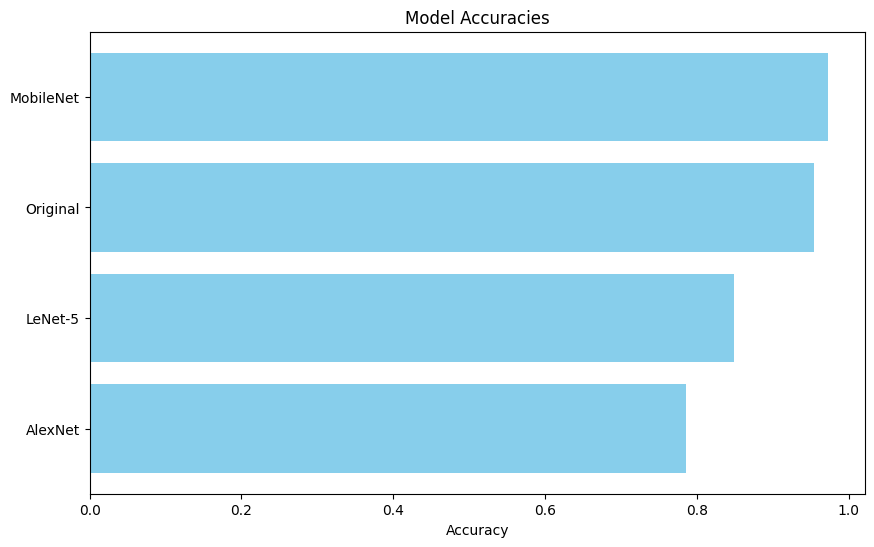

In [36]:
import matplotlib.pyplot as plt
# Plot accuracies
model_names = [name for name, accuracy in accuracies]
model_accuracies = [accuracy for name, accuracy in accuracies]
best_model_name, best_accuracy = accuracies[0]

plt.figure(figsize=(10, 6))
plt.barh(model_names, model_accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.title('Model Accuracies')
plt.gca().invert_yaxis()  # Highest accuracy at the top
plt.show()